In [ ]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Mounted at /content/MyDrive


In [ ]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
import statistics
from scipy.signal import savgol_filter, butter, filtfilt

class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

In [ ]:
class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)

        self.scaler_save_path = os.path.join(self.config.dataset_root, dataset_name, "scaler.pkl")
        self.scaler = joblib.load(self.scaler_save_path) if os.path.exists(self.scaler_save_path) else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])

        if self.input_format == "wav":
            combined_data, _ = get_data_from_wav_file(file_path)
        elif self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


In [ ]:
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))


  print(rmse_1)
  print(rmse_2)
  print(rmse_3)


  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]


  print("\n")
  print(p_1)
  print(p_2)
  print(p_3)


              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)
  print('Mean: %.3f' % m,'+/- %.3f' %SD)

  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)
  print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)



  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss




In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import time
from scipy.stats import pearsonr



def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = np.zeros(len(config.channels_joints))
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())

            loss = criterion(output, target.to(device).float())

            batch_rmse,batch_pcc,_,_,_ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints))

            total_loss += np.mean(loss.detach().cpu().numpy(), axis=0)
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename):
    if torch.cuda.is_available():
        model.cuda()

    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse,batch_pcc,_,_,_ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints))
            epoch_train_loss += np.mean(loss.detach().cpu().numpy(), axis=0)
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {avg_train_loss.mean():.4f}, Validation Loss: {avg_val_loss.mean():.4f}")

        # Checkpoint every 10 epochs, run test set evaluation, and log channel-wise metrics
        if (epoch + 1) % 1 == 0:
            avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
            test_losses.append(avg_test_loss)
            test_pccs.append(avg_test_pcc)
            test_rmses.append(avg_test_rmse)

            # Save checkpoint, including channel-wise metrics
            save_checkpoint(
                model,
                optimizer,
                epoch,
                f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
                train_loss=avg_train_loss,
                val_loss=avg_val_loss,
                test_loss=avg_test_loss,
                channelwise_metrics={
                    'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                    'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                    'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
                }
            )

        # Early stopping logic
        if avg_val_loss.mean() < best_val_loss:
            best_val_loss = avg_val_loss.mean()
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses


In [ ]:
class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'wav':
            self._process_and_save_patients_wav(self.config.train_subjects, "train")
            self._process_and_save_patients_wav(self.config.test_subjects, "test")
        elif self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _process_and_save_patients_wav(self, patient_id_list, split):
        total_data = []
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            for session_index in tqdm(range(len(self.config.train_subjects)), desc=f"Processing sessions for {patient_id}", leave=False):
                imu_data, imu_sample_rate = self._load_wav_file(patient_id, session_index, "IMU")
                joints_data, joints_sample_rate = self._load_wav_file(patient_id, session_index, "JOINTS")
                emg_data, emg_sample_rate = self._load_wav_file(patient_id, session_index, "EMG")

                imu_data = self._resample_data(imu_data, imu_sample_rate)
                joints_data = self._resample_data(joints_data, joints_sample_rate)
                emg_data = self._resample_data(emg_data, emg_sample_rate)

                combined_data = torch.cat((imu_data, joints_data, emg_data), dim=1)
                total_data.append(combined_data.cpu().numpy())

        if self.save_h5:
            self._save_to_h5(total_data, split)
        else:
            for combined_data in total_data:
                self._save_windowed_data(combined_data, patient_id, session_index, split)

    def _load_wav_file(self, patient_id, session_index, file_type):
        file_path = os.path.join(self.data_folder_path, patient_id, f"run{session_index}_{file_type}.wav")
        data, sample_rate = get_data_from_wav_file(file_path)
        return torch.tensor(data, dtype=torch.float32), sample_rate

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))


In [ ]:
import shutil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=51,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_5','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)





In [ ]:
reshard = False

if reshard:
  if not os.path.exists("/content/sd_datacollection"):
    #copy over
    shutil.copytree(config.data_folder_name, "/content/sd_datacollection")
    config.data_folder_name = "/content/sd_datacollection"
  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))



In [ ]:
# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# Train the model
model = teacher(
    input_acc=len(config.channels_imu_acc),
    input_gyr=len(config.channels_imu_gyr),
    input_emg=len(config.channels_emg)
)

In [ ]:

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

print(acc.dtype)
print(gyro.dtype)
print(target.dtype)
print(emg.dtype)


torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])
torch.float32
torch.float32
torch.float32
torch.float32


In [ ]:
model = teacher(18, 18, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#train teacher
model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(device,train_loader, val_loader, test_loader,config.lr, config.epochs, model, 'new_opensimmodel_first_run_all_subjects')

Epoch 1/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 344.7708, Validation Loss: 104.8538


Epoch 2/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 100.2198, Validation Loss: 68.9976


Epoch 3/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 81.5185, Validation Loss: 60.7758


Epoch 4/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 70.3771, Validation Loss: 57.4246


Epoch 5/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 61.5472, Validation Loss: 57.0213


Epoch 6/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 56.9860, Validation Loss: 46.7275


Epoch 7/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 51.4557, Validation Loss: 40.6601


Epoch 8/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 47.5077, Validation Loss: 43.4562


Epoch 9/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 46.2583, Validation Loss: 34.3790


Epoch 10/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 42.5766, Validation Loss: 36.8873
Checkpoint saved for epoch 10


Epoch 11/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 39.2780, Validation Loss: 29.0198


Epoch 12/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 35.7505, Validation Loss: 28.3501


Epoch 13/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 34.4296, Validation Loss: 37.6883


Epoch 14/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 37.0693, Validation Loss: 25.7896


Epoch 15/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 30.6267, Validation Loss: 26.0185


Epoch 16/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 30.8258, Validation Loss: 27.2590


Epoch 17/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 31.2750, Validation Loss: 34.5663


Epoch 18/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 27.9509, Validation Loss: 23.0081


Epoch 19/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 25.0265, Validation Loss: 21.5611


Epoch 20/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 24.6752, Validation Loss: 23.0353
Checkpoint saved for epoch 20


Epoch 21/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 23.7335, Validation Loss: 21.4818


Epoch 22/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 27.3119, Validation Loss: 20.0115


Epoch 23/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 23.0299, Validation Loss: 19.4293


Epoch 24/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 21.2409, Validation Loss: 17.6943


Epoch 25/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 20.4679, Validation Loss: 20.4179


Epoch 26/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 21.9700, Validation Loss: 19.8875


Epoch 27/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 21.2464, Validation Loss: 18.4162


Epoch 28/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 20.5282, Validation Loss: 20.5388


Epoch 29/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 20.3097, Validation Loss: 18.6491


Epoch 30/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 19.1173, Validation Loss: 16.3731
Checkpoint saved for epoch 30


Epoch 31/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 18.4333, Validation Loss: 15.8243


Epoch 32/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 17.4056, Validation Loss: 17.3721


Epoch 33/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 18.3551, Validation Loss: 17.0283


Epoch 34/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 17.0247, Validation Loss: 18.5605


Epoch 35/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 17.1230, Validation Loss: 16.4299


Epoch 36/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 16.8724, Validation Loss: 15.1309


Epoch 37/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 15.7277, Validation Loss: 13.0674


Epoch 38/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 15.8384, Validation Loss: 13.4301


Epoch 39/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 15.3320, Validation Loss: 14.9387


Epoch 40/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 15.8244, Validation Loss: 14.0211
Checkpoint saved for epoch 40


Epoch 41/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 14.8383, Validation Loss: 13.7206


Epoch 42/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 15.2338, Validation Loss: 12.8496


Epoch 43/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 14.4308, Validation Loss: 11.8746


Epoch 44/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 16.0718, Validation Loss: 14.0136


Epoch 45/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 17.9233, Validation Loss: 22.9077


Epoch 46/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 15.0796, Validation Loss: 12.1507


Epoch 47/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 12.7992, Validation Loss: 12.2919


Epoch 48/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 11.8934, Validation Loss: 9.0925


Epoch 49/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 11.9907, Validation Loss: 11.8853


Epoch 50/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 11.8763, Validation Loss: 8.8080
Checkpoint saved for epoch 50


Epoch 51/51 Training:   0%|          | 0/653 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 11.5720, Validation Loss: 11.2371
Total training time: 16715.78 seconds


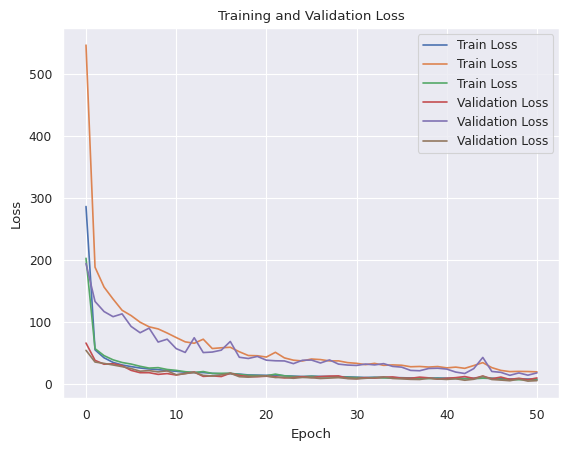

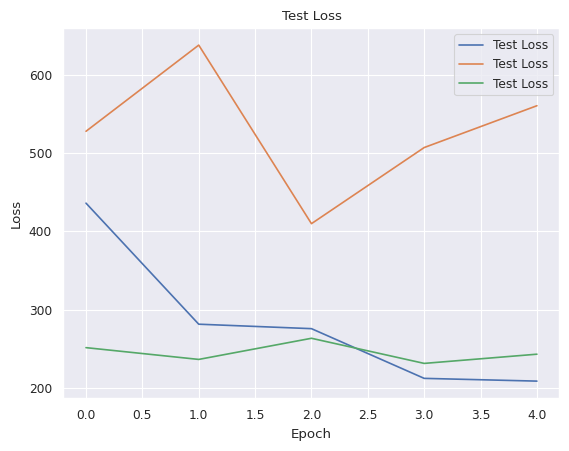

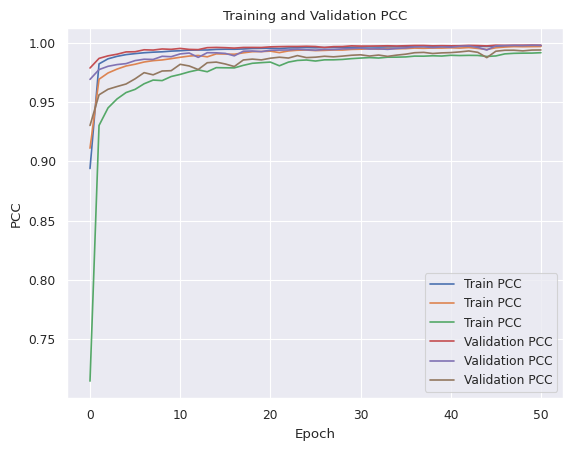

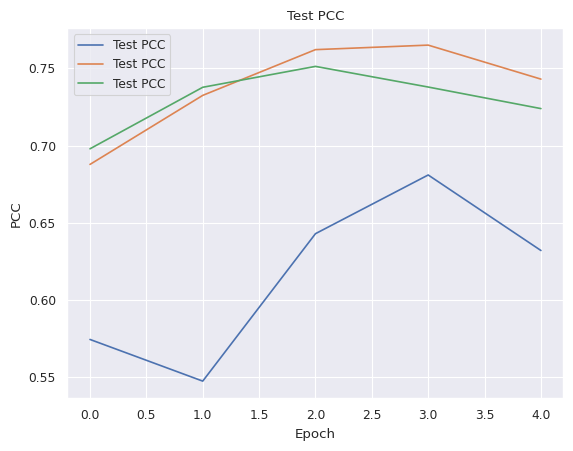

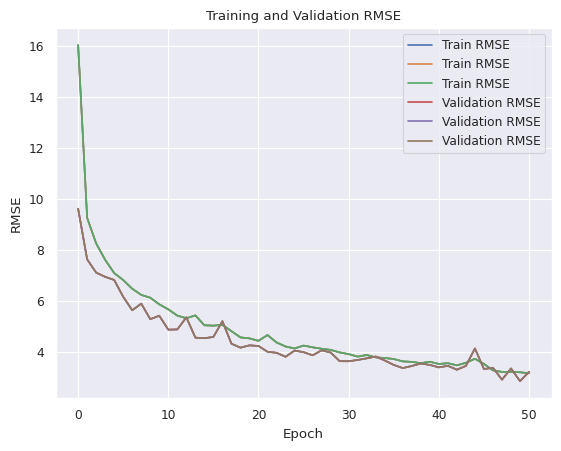

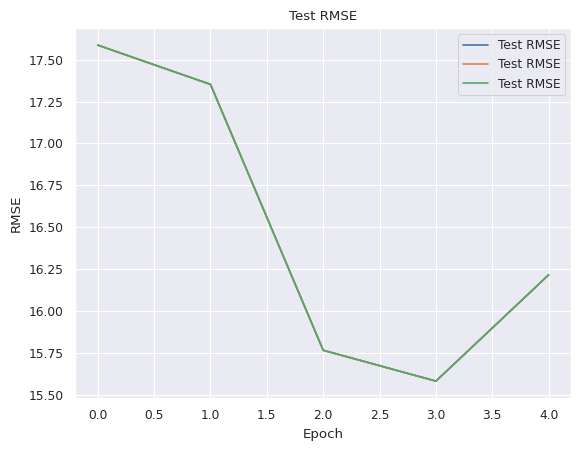

In [ ]:
# prompt: plot necessary values

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


plt.plot(train_pccs, label='Train PCC')
plt.plot(val_pccs, label='Validation PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Training and Validation PCC')
plt.legend()
plt.show()

plt.plot(test_pccs, label='Test PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Test PCC')
plt.legend()
plt.show()

plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()
plt.show()

In [ ]:
class student(nn.Module):
    def __init__(self, input_acc, input_gyr, drop_prob=0.25, w=100):
        super(student, self).__init__()
        self.w=w

        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)

        self.fc = nn.Linear(2*2*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(2*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*2, 2*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*2*128+128, 2*2*128+128), nn.Sigmoid())


    def forward(self, x_acc, x_gyr):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)

        x=torch.cat((x_acc,x_gyr),dim=-1)

        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        out_3=x_1+x_2


        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        return out



In [ ]:
def train_student(device, train_loader, val_loader, learn_rate, epochs, model, filename, imu_indices):
    if torch.cuda.is_available():
        model.cuda()

    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    train_channel_losses = []
    val_channel_losses = []
    train_pccs = []
    val_pccs = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_train_loss = 0
        epoch_train_channel_loss = np.zeros(len(config.channels_joints))
        epoch_val_channel_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_val_pcc = np.zeros(len(config.channels_joints))

        for data_acc, data_gyr, target, data_EMG in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training"):
            optimizer.zero_grad()
            data_acc_selected = data_acc[:, :, imu_indices].to(device).float()
            data_gyr_selected = data_gyr[:, :, imu_indices].to(device).float()
            output = model(data_acc_selected, data_gyr_selected)
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

            batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
            epoch_train_channel_loss += batch_loss

            batch_pcc = compute_pcc(output.detach().cpu().numpy(), target.detach().cpu().numpy())
            epoch_train_pcc += batch_pcc

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_channel_losses.append(epoch_train_channel_loss / len(train_loader))
        train_pccs.append(epoch_train_pcc / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data_acc, data_gyr, target, data_EMG in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} Validation"):
                data_acc_selected = data_acc[:, :, imu_indices].to(device).float()
                data_gyr_selected = data_gyr[:, :, imu_indices].to(device).float()
                output = model(data_acc_selected, data_gyr_selected)
                loss = criterion(output, target.to(device).float())
                epoch_val_loss += loss.item()

                batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
                epoch_val_channel_loss += batch_loss

                batch_pcc = compute_pcc(output.detach().cpu().numpy(), target.detach().cpu().numpy())
                epoch_val_pcc += batch_pcc

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_channel_losses.append(epoch_val_channel_loss / len(val_loader))
        val_pccs.append(epoch_val_pcc / len(val_loader))

        epoch_end_time = time.time()
        epoch_training_time = epoch_end_time - epoch_start_time

        print(f"Epoch: {epoch + 1}, time: {epoch_training_time:.4f}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    return model, train_losses, val_losses, train_channel_losses, val_channel_losses, train_pccs, val_pccs


In [ ]:

# Load teacher model from checkpoint
teacher_cqweheckpoint = "/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata_[1,2,3,7,9,10]/retrained_teacher_model_train_subject_10_subject_2_subject_3_subject_7_subject_9_test_subject_1_epoch_175.pth"
model_teacher = teacher(18, 18,3)
model_teacher.load_state_dict(torch.load(teacher_checkpoint)['model_state_dict'])

In [ ]:
def evaluate_model(model, loader, device, output_dim=3):
    model.eval()
    model.to(device)  # Ensure the model is on the correct device
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            data_acc, data_gyr, data_EMG = data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float()
            target = target.to(device)
            output, _ = model(data_acc, data_gyr, data_EMG)
            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, data_EMG, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()
    print(yhat_4.shape)

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=output_dim)
    return np.hstack([rmse, p])

# # Ensure that the device is specified
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Call the evaluate_model function
# evaluate_model(model_teacher, test_loader, device)

In [ ]:
# Define your model (you might need to redefine it for each training session to avoid parameter reuse)
from scipy.stats import pearsonr
def create_student_model(input_size):
    return student(input_size, input_size)

# IMU indices for each student
imu_indices_list = [
    [0, 1, 2],              # First IMU (X, Y, Z)
    [3, 4, 5],
    [0, 1, 2, 3, 4, 5],     # First and second IMUs (X, Y, Z for each)
    # [0, 1, 2, 3, 4, 5, 6, 7, 8], # First, second, and third IMUs (X, Y, Z for each)
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], # Up to sixth IMU
]


models = []
all_train_losses = []
all_val_losses = []
all_train_channel_losses = []
all_val_channel_losses = []
all_train_pccs = []
all_val_pccs = []

# Train each student model with different IMU indices
for i, imu_indices in enumerate(imu_indices_list):
    filename = f"student_model_{i+1}.pth"
    model = create_student_model(input_size=len(imu_indices))
    model, train_losses, val_losses, train_channel_losses, val_channel_losses, train_pccs, val_pccs = train_student(
        device, train_loader, val_loader, config.lr, 40, model, filename, imu_indices
    )
    models.append(model)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_channel_losses.append(train_channel_losses)
    all_val_channel_losses.append(val_channel_losses)
    all_train_pccs.append(train_pccs)
    all_val_pccs.append(val_pccs)


In [ ]:
def plot_results(all_train_channel_losses, all_val_channel_losses, all_train_pccs, all_val_pccs, config):
    channels = config.channels_joints
    num_models = len(all_train_channel_losses)

    for model_idx in range(num_models):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Model {model_idx + 1} Metrics')

        train_channel_losses = all_train_channel_losses[model_idx]
        val_channel_losses = all_val_channel_losses[model_idx]
        train_pccs = all_train_pccs[model_idx]
        val_pccs = all_val_pccs[model_idx]
        epochs = len(train_channel_losses)

        # Plot RMSE for each channel
        for channel_idx, channel in enumerate(channels):
            axs[0, 0].plot(range(epochs), [loss[channel_idx] for loss in train_channel_losses], label=f'Train {channel}')
            axs[0, 0].plot(range(epochs), [loss[channel_idx] for loss in val_channel_losses], label=f'Val {channel}')

        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('RMSE (degrees)')
        axs[0, 0].set_title('Channel-wise RMSE over Epochs')
        axs[0, 0].legend()

        # Plot PCC for each channel
        for channel_idx, channel in enumerate(channels):
            axs[0, 1].plot(range(epochs), [pcc[channel_idx] for pcc in train_pccs], label=f'Train {channel}')
            axs[0, 1].plot(range(epochs), [pcc[channel_idx] for pcc in val_pccs], label=f'Val {channel}')

        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('PCC')
        axs[0, 1].set_title('Channel-wise PCC over Epochs')
        axs[0, 1].legend()

        # Plot averaged RMSE for train and validation
        avg_train_losses = [np.mean([loss[channel_idx] for channel_idx in range(len(channels))]) for loss in train_channel_losses]
        avg_val_losses = [np.mean([loss[channel_idx] for channel_idx in range(len(channels))]) for loss in val_channel_losses]

        axs[1, 0].plot(range(epochs), avg_train_losses, label='Avg Train')
        axs[1, 0].plot(range(epochs), avg_val_losses, label='Avg Val')

        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Average RMSE (degrees)')
        axs[1, 0].set_title('Average RMSE over Epochs')
        axs[1, 0].legend()

        # Plot averaged PCC for train and validation
        avg_train_pccs = [np.mean([pcc[channel_idx] for channel_idx in range(len(channels))]) for pcc in train_pccs]
        avg_val_pccs = [np.mean([pcc[channel_idx] for channel_idx in range(len(channels))]) for pcc in val_pccs]

        axs[1, 1].plot(range(epochs), avg_train_pccs, label='Avg Train')
        axs[1, 1].plot(range(epochs), avg_val_pccs, label='Avg Val')

        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Average PCC')
        axs[1, 1].set_title('Average PCC over Epochs')
        axs[1, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_results(all_train_channel_losses, all_val_channel_losses, all_train_pccs, all_val_pccs, config)

In [ ]:

def evaluate_model_on_test(model, test_loader, device, imu_indices):
    model.eval()
    model.to(device)
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, emg) in enumerate(test_loader):
            # Extract only the relevant indices
            data_acc = data_acc[:, :, imu_indices].to(device).float()
            data_gyr = data_gyr[:, :, imu_indices].to(device).float()
            target = target.to(device)
            output = model(data_acc, data_gyr)
            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=3)
    return rmse, p

# Evaluate each model on the test set
all_test_rmse = []
all_test_pcc = []

for model, imu_indices in zip(models, imu_indices_list):
    rmse, pcc = evaluate_model_on_test(model, test_loader, device, imu_indices)
    all_test_rmse.append(rmse)
    all_test_pcc.append(pcc)

# Colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot the results
def plot_comparison_bar_graph(all_test_rmse, all_test_pcc, imu_indices_list):
    num_models = len(all_test_rmse)
    model_labels = [f"Model {i+1}" for i in range(num_models)]

    # Bar plot for RMSE
    plt.figure(figsize=(12, 6))
    plt.bar(model_labels, [np.mean(rmse) for rmse in all_test_rmse], color=colors[:num_models], alpha=0.6, label='RMSE')
    plt.xlabel('Models')
    plt.ylabel('Average RMSE (degrees)')
    plt.ylim(0, 30)
    plt.title('Average RMSE for Each Model on Test Set')
    plt.legend()
    plt.show()

    # Bar plot for PCC
    plt.figure(figsize=(12, 6))
    plt.bar(model_labels, [np.mean(pcc) for pcc in all_test_pcc], color=colors[:num_models], alpha=0.6, label='PCC')
    plt.xlabel('Models')
    plt.ylabel('Average PCC')
    plt.ylim(0, 1)
    plt.title('Average PCC for Each Model on Test Set')
    plt.legend()
    plt.show()

plot_comparison_bar_graph(all_test_rmse, all_test_pcc, imu_indices_list)

In [ ]:
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd

class student_KD(nn.Module):
    def __init__(self, input_acc, input_gyr, drop_prob=0.25, w=100):
        super(student_KD, self).__init__()
        self.w = w
        self.encoder_1_acc = Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr = Encoder_1(input_gyr, drop_prob)

        self.encoder_2_acc = Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr = Encoder_2(input_gyr, drop_prob)

        self.BN_acc = nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr = nn.BatchNorm1d(input_gyr, affine=False)

        self.fc_kd = nn.Linear(2 * 128, 2 * 128)
        self.fc = nn.Linear(2 * 2 * 128 + 128, 3)
        self.dropout = nn.Dropout(p=0.05)

        self.gate_1 = GatingModule(128)
        self.gate_2 = GatingModule(128)

        self.weighted_feat = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.attention = nn.MultiheadAttention(2 * 128, 4, batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128 * 2, 2 * 128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2 * 2 * 128 + 128, 2 * 2 * 128 + 128), nn.Sigmoid())

    def forward(self, x_acc, x_gyr):
        x_acc_1 = x_acc.view(x_acc.size(0) * x_acc.size(1), x_acc.size(-1))
        x_gyr_1 = x_gyr.view(x_gyr.size(0) * x_gyr.size(1), x_gyr.size(-1))

        x_acc_1 = self.BN_acc(x_acc_1)
        x_gyr_1 = self.BN_gyr(x_gyr_1)

        x_acc_2 = x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2 = x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))

        x_acc_1 = self.encoder_1_acc(x_acc_2)
        x_gyr_1 = self.encoder_1_gyr(x_gyr_2)

        x_acc_2 = self.encoder_2_acc(x_acc_2)
        x_gyr_2 = self.encoder_2_gyr(x_gyr_2)

        x_acc = self.gate_1(x_acc_1, x_acc_2)
        x_gyr = self.gate_2(x_gyr_1, x_gyr_2)

        x = torch.cat((x_acc, x_gyr), dim=-1)
        x_KD = self.fc_kd(x)

        out_1, attn_output_weights = self.attention(x, x, x)
        gating_weights = self.gating_net(x)
        out_2 = gating_weights * x

        weights_1 = self.weighted_feat(x[:, :, 0:128])
        weights_2 = self.weighted_feat(x[:, :, 128:2 * 128])
        x_1 = weights_1 * x[:, :, 0:128]
        x_2 = weights_2 * x[:, :, 128:2 * 128]
        out_3 = x_1 + x_2

        out = torch.cat((out_1, out_2, out_3), dim=-1)
        gating_weights_1 = self.gating_net_1(out)
        out = gating_weights_1 * out

        out = self.fc(out)
        return out, x_KD

In [ ]:

def train_student_with_kd(device, alpha, beta, train_loader, val_loader, learn_rate, epochs, student_model, filename, teacher_model, imu_indices):
    student_model.to(device)
    teacher_model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(student_model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    train_channel_losses = []
    val_channel_losses = []
    train_pccs = []
    val_pccs = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        student_model.train()
        epoch_train_loss = 0
        epoch_train_channel_loss = np.zeros(len(config.channels_joints))
        epoch_val_channel_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_val_pcc = np.zeros(len(config.channels_joints))

        for data_acc, data_gyr, target, data_EMG in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training"):
            optimizer.zero_grad()
            data_acc_selected = data_acc[:, :, imu_indices].to(device).float()
            data_gyr_selected = data_gyr[:, :, imu_indices].to(device).float()

            student_output, x_student_1 = student_model(data_acc_selected, data_gyr_selected)
            with torch.no_grad():
                data_acc_device = data_acc.to(device).float()
                data_gyr_device = data_gyr.to(device).float()
                data_EMG_device = data_EMG.to(device).float()
                teacher_output, x_teacher_1 = teacher_model(data_acc_device, data_gyr_device, data_EMG_device)

            target_device = target.to(device).float()
            loss = criterion(student_output, target_device) + alpha * criterion(student_output, teacher_output) + beta * criterion(x_student_1, x_teacher_1)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

            batch_loss = np.mean((student_output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
            epoch_train_channel_loss += batch_loss

            batch_pcc = compute_pcc(student_output.detach().cpu().numpy(), target.detach().cpu().numpy())
            epoch_train_pcc += batch_pcc

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_channel_losses.append(epoch_train_channel_loss / len(train_loader))
        train_pccs.append(epoch_train_pcc / len(train_loader))

        student_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data_acc, data_gyr, target, data_EMG in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} Validation"):
                data_acc_selected = data_acc[:, :, imu_indices].to(device).float()
                data_gyr_selected = data_gyr[:, :, imu_indices].to(device).float()
                output, _ = student_model(data_acc_selected, data_gyr_selected)
                loss = criterion(output, target.to(device).float())
                epoch_val_loss += loss.item()

                batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
                epoch_val_channel_loss += batch_loss

                batch_pcc = compute_pcc(output.detach().cpu().numpy(), target.detach().cpu().numpy())
                epoch_val_pcc += batch_pcc

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_channel_losses.append(epoch_val_channel_loss / len(val_loader))
        val_pccs.append(epoch_val_pcc / len(val_loader))

        epoch_end_time = time.time()
        epoch_training_time = epoch_end_time - epoch_start_time

        print(f"Epoch: {epoch + 1}, time: {epoch_training_time:.4f}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(student_model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    return student_model, train_losses, val_losses, train_channel_losses, val_channel_losses, train_pccs, val_pccs

# IMU indices for each student
imu_indices_list = [
    [0, 1, 2],# First IMU (X, Y, Z)
    [3,4,5],
    [0, 1, 2, 3, 4, 5],     # First and second IMUs (X, Y, Z for each)
    # [0, 1, 2, 3, 4, 5, 6, 7, 8], # First, second, and third IMUs (X, Y, Z for each)
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], # Up to sixth IMU
]


# Load teacher model from checkpoint
teacher_checkpoint = "/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata_[1,2,3,7,9,10]/retrained_teacher_model_train_subject_10_subject_2_subject_3_subject_7_subject_9_test_subject_1_epoch_175.pth"
model_teacher = teacher(18, 18,3)
model_teacher.load_state_dict(torch.load(teacher_checkpoint)['model_state_dict'])

# Store all KD models and their metrics
kd_models = []
kd_train_losses = []
kd_val_losses = []
kd_train_channel_losses = []
kd_val_channel_losses = []
kd_train_pccs = []
kd_val_pccs = []

# Training hyperparameters for KD
alpha = 0.5
beta = 0.5

def create_student_model_KD(input_size):
    return student_KD(input_size, input_size)

# Train each student model with different IMU indices using KD
for i, imu_indices in enumerate(imu_indices_list):
    filename = f"student_model_kd_{i+1}.pth"
    model = create_student_model_KD(input_size=len(imu_indices))
    model, train_losses, val_losses, train_channel_losses, val_channel_losses, train_pccs, val_pccs = train_student_with_kd(
        device, alpha, beta, train_loader, val_loader, config.lr, 40, model, filename, model_teacher, imu_indices
    )
    kd_models.append(model)
    kd_train_losses.append(train_losses)
    kd_val_losses.append(val_losses)
    kd_train_channel_losses.append(train_channel_losses)
    kd_val_channel_losses.append(val_channel_losses)
    kd_train_pccs.append(train_pccs)
    kd_val_pccs.append(val_pccs)



In [ ]:
# temp_checkpoint = "/content/student_model_1.pth"
# model_temp = student(3,3)
# model_temp.load_state_dict(torch.load(temp_checkpoint))

# kd_models = [model_temp]

def evaluate_model_on_test(model, test_loader, device, imu_indices):
    model.eval()
    model.to(device)
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, emg) in enumerate(test_loader):
            # Extract only the relevant indices
            data_acc = data_acc[:, :, imu_indices].to(device).float()
            data_gyr = data_gyr[:, :, imu_indices].to(device).float()
            target = target.to(device)

            # Unpack the output from the model
            output = model(data_acc, data_gyr)

            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=3)
    return rmse, p


# Evaluate each model on the test set
all_test_rmse_kd = []
all_test_pcc_kd = []

for model, imu_indices in zip(kd_models, imu_indices_list):
    rmse, pcc = evaluate_model_on_test(model, test_loader, device, imu_indices)
    all_test_rmse_kd.append(rmse)
    all_test_pcc_kd.append(pcc)

# Colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot the results
def plot_comparison_bar_graph(all_test_rmse, all_test_pcc, imu_indices_list):
    num_models = len(all_test_rmse)
    model_labels = [f"Model {i+1}" for i in range(num_models)]

    # Bar plot for RMSE
    plt.figure(figsize=(12, 6))
    plt.bar(model_labels, [np.mean(rmse) for rmse in all_test_rmse], color=colors[:num_models], alpha=0.6, label='RMSE')
    plt.xlabel('Models')
    plt.ylabel('Average RMSE (degrees)')
    plt.ylim(0, 30)
    plt.title('Average RMSE for Each Model on Test Set')
    plt.legend()
    plt.show()

    # Bar plot for PCC
    plt.figure(figsize=(12, 6))
    plt.bar(model_labels, [np.mean(pcc) for pcc in all_test_pcc], color=colors[:num_models], alpha=0.6, label='PCC')
    plt.xlabel('Models')
    plt.ylabel('Average PCC')
    plt.ylim(0, 1)
    plt.title('Average PCC for Each Model on Test Set')
    plt.legend()
    plt.show()

plot_comparison_bar_graph(all_test_rmse_kd, all_test_pcc_kd, imu_indices_list)


In [ ]:
print(np.array(kd_train_losses).shape)
print(np.array(kd_val_losses).shape)
print(np.array(kd_train_channel_losses).shape)
print(np.array(kd_val_channel_losses).shape)


plot_results(kd_train_channel_losses, kd_val_channel_losses, kd_train_pccs, kd_val_pccs,config)

In [ ]:
#concat RMSE bars and PCC bars combined_rmse = all_test_rmse,all_test_rmse_kd,

print(all_test_rmse)
print(all_test_rmse_kd)
print(all_test_pcc)
print(all_test_pcc_kd)

process_file





In [ ]:
sns.set_theme("paper")
import glob
# Butterworth lowpass filter
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Prediction function
def RMSE_prediction(yhat_4, test_y, output_dim):
    s1 = yhat_4.shape[0] * yhat_4.shape[1]
    test_o = test_y.reshape((-1, output_dim))
    yhat = yhat_4.reshape((-1, output_dim))

    y_1_no, y_2_no, y_3_no = yhat[:, 0], yhat[:, 1], yhat[:, 2]
    y_test_1, y_test_2, y_test_3 = test_o[:, 0], test_o[:, 1], test_o[:, 2]

    cutoff, fs, order = 6, 200, 4

    # Filtered predictions
    y_1_filtered = butter_lowpass_filter(y_1_no, cutoff, fs, order)
    y_2_filtered = butter_lowpass_filter(y_2_no, cutoff, fs, order)
    y_3_filtered = butter_lowpass_filter(y_3_no, cutoff, fs, order)

    # Calculate RMSE
    rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_1_no))
    rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_2_no))
    rmse_3 = np.sqrt(mean_squared_error(y_test_3, y_3_no))

    rmse_1_filtered = np.sqrt(mean_squared_error(y_test_1, y_1_filtered))
    rmse_2_filtered = np.sqrt(mean_squared_error(y_test_2, y_2_filtered))
    rmse_3_filtered = np.sqrt(mean_squared_error(y_test_3, y_3_filtered))

    print("RMSE without filter:", rmse_1, rmse_2, rmse_3)
    print("RMSE with filter:", rmse_1_filtered, rmse_2_filtered, rmse_3_filtered)

    # Correlation
    p_1 = np.corrcoef(y_1_no, y_test_1)[0, 1]
    p_2 = np.corrcoef(y_2_no, y_test_2)[0, 1]
    p_3 = np.corrcoef(y_3_no, y_test_3)[0, 1]
    p_1_filtered = np.corrcoef(y_1_filtered, y_test_1)[0, 1]
    p_2_filtered = np.corrcoef(y_2_filtered, y_test_2)[0, 1]
    p_3_filtered = np.corrcoef(y_3_filtered, y_test_3)[0, 1]

    print("\nCorrelation without filter:", p_1, p_2, p_3)
    print("Correlation with filter:", p_1_filtered, p_2_filtered, p_3_filtered)

    return {
        'rmse': [rmse_1, rmse_2, rmse_3],
        'rmse_filtered': [rmse_1_filtered, rmse_2_filtered, rmse_3_filtered],
        'pcc': [p_1, p_2, p_3],
        'pcc_filtered': [p_1_filtered, p_2_filtered, p_3_filtered],
        'y_no': [y_1_no, y_2_no, y_3_no],
        'y_filtered': [y_1_filtered, y_2_filtered, y_3_filtered],
        'y_test': [y_test_1, y_test_2, y_test_3]
    }

# Plot function
def plot_predictions(results, title, ax, channel):
    y_no = results['y_no'][channel]
    y_filtered = results['y_filtered'][channel]
    y_test = results['y_test'][channel]

    ax.plot(y_test[:3000], label='Ground Truth')
    ax.plot(y_no[:3000], label='Predicted (No Filter)')
    ax.plot(y_filtered[:3000], label='Predicted (Filtered)')
    ax.set_title(title)
    ax.set_xlabel('Time (centiseconds)')
    ax.set_ylabel('Joint Angle (degrees)')
    ax.set_ylim(-180, 180)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

    # Adding RMSE values
    rmse = results['rmse'][channel]
    rmse_filtered = results['rmse_filtered'][channel]

    textstr = '\n'.join((
        f'RMSE (No Filter): {rmse:.3f}',
        f'RMSE (Filtered): {rmse_filtered:.3f}',
    ))

    ax.text(0.98, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Process file
def process_file_student(file_path, student_model):
    df = pd.read_csv(file_path)
    print("processing file {}".format(file_path))

    columns_imu_acc = config.channels_imu_acc
    columns_imu_gyr = config.channels_imu_gyr
    columns_joints = config.channels_joints

    input_acc = df[columns_imu_acc].values
    input_gyr = df[columns_imu_gyr].values
    input_emg = df[config.channels_emg].values
    target_data = df[columns_joints].values

    acc_tensor = torch.tensor(input_acc, dtype=torch.float32).unsqueeze(0)
    gyr_tensor = torch.tensor(input_gyr, dtype=torch.float32).unsqueeze(0)
    emg_tensor = torch.tensor(input_emg, dtype=torch.float32).unsqueeze(0)
    target_tensor = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

    window_size = 100
    predictions_teacher = []

    with torch.no_grad():
        for i in range(0, acc_tensor.shape[1] - window_size + 1, window_size):
            acc_window = acc_tensor[:, i:i + window_size, :3].to(device)
            gyr_window = gyr_tensor[:, i:i + window_size, :3].to(device)
            emg_window = emg_tensor[:, i:i + window_size, :3].to(device)

            output, _ = student_model(acc_window, gyr_window)
            predictions_teacher.append(output.cpu().numpy())

    predictions_teacher = np.concatenate(predictions_teacher, axis=1)
    predictions_teacher = predictions_teacher.reshape(-1, predictions_teacher.shape[-1])
    target_tensor_np = target_tensor.cpu().numpy().squeeze(0)[:predictions_teacher.shape[0]]

    print(f"predictions_teacher shape: {predictions_teacher.shape}")
    print(f"target_tensor_np shape: {target_tensor_np.shape}")

    return RMSE_prediction(predictions_teacher, target_tensor_np, target_tensor_np.shape[1])


# Main processing and plotting
combined_folder_path = f'/content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/'
file_paths = glob.glob(os.path.join(combined_folder_path, '*.csv'))
print(f'Found {len(file_paths)} files for processing.')

num_files = len(file_paths)
num_channels = 3

fig, axes = plt.subplots(num_files, num_channels, figsize=(15, 5 * num_files))

for i, file_path in enumerate(file_paths):
    print(f'Processing file: {file_path}')
    results = process_file_student(file_path, kd_models[0])

    plot_predictions(results, f'Elbow Flexion - {os.path.basename(file_path[:-4])}', axes[i, 0], 0)
    plot_predictions(results, f'Arm Flexion - {os.path.basename(file_path[:-4])}', axes[i, 1], 1)
    plot_predictions(results, f'Arm Adduction - {os.path.basename(file_path[:-4])}', axes[i, 2], 2)

plt.tight_layout()
plt.show()

In [ ]:
def run_models_and_save_csv(file_path, teacher_model, student_model):
    # Load CSV
    df = pd.read_csv(file_path)

    # Create copies for teacher and student predictions
    df_teacher = df.copy()
    df_student = df.copy()

    # Process file for teacher model
    results_teacher = process_file(file_path, teacher_model)
    elbow_flex_pred_teacher_filtered = results_teacher['y_filtered'][0]  # Elbow flexion predictions (filtered) from teacher model

    # Process file for student model
    results_student = process_file_student(file_path, student_model)
    elbow_flex_pred_student_filtered = results_student['y_filtered'][0]  # Elbow flexion predictions (filtered) from student model

    # Determine the minimum length
    min_length = min(len(df), len(elbow_flex_pred_teacher_filtered), len(elbow_flex_pred_student_filtered))

    # Tailor predictions to the shorter length
    elbow_flex_pred_teacher_filtered = elbow_flex_pred_teacher_filtered[:min_length]
    elbow_flex_pred_student_filtered = elbow_flex_pred_student_filtered[:min_length]

    # Truncate the dataframes to the minimum length
    df_teacher = df_teacher.iloc[:min_length]
    df_student = df_student.iloc[:min_length]

    # Add predictions to respective dataframes
    df_teacher['elbow_flex_pred'] = elbow_flex_pred_teacher_filtered
    df_student['elbow_flex_pred'] = elbow_flex_pred_student_filtered

    # Save new CSV files
    teacher_csv_path = os.path.join('teacher.csv')
    student_csv_path = os.path.join( 'student.csv')

    df_teacher.to_csv(teacher_csv_path, index=False)
    df_student.to_csv(student_csv_path, index=False)

    print(f'Teacher predictions saved to {teacher_csv_path}')
    print(f'Student predictions saved to {student_csv_path}')

In [ ]:
teacher_checkpoint = "/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata_[1,2,3,7,9,10]/retrained_teacher_model_train_subject_10_subject_2_subject_3_subject_7_subject_9_test_subject_1_epoch_175.pth"
model_teacher = teacher(18, 18,3)
model_teacher.load_state_dict(torch.load(teacher_checkpoint)['model_state_dict'])

model_teacher.eval()
model_teacher.to(device)

file_path = '/content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/P001_T001_elbowflexion_slow_combined.csv'
run_models_and_save_csv(file_path, teacher_model=model_teacher, student_model=kd_models[0])

In [ ]:
def RMSE_prediction(yhat_4,test_y, output_dim):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]
  #y_4_no=yhat[:,3]
  #y_5_no=yhat[:,4]
  #y_6_no=yhat[:,5]
  #y_7_no=yhat[:,6]
  #y_8_no=yhat[:,7]
  #y_9_no=yhat[:,8]
  #y_10_no=yhat[:,9]


  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no
  #y_4=y_4_no
  #y_5=y_5_no
  #y_6=y_6_no
  #y_7=y_7_no



  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]
  #y_test_4=test_o[:,3]
  #y_test_5=test_o[:,4]
  #y_test_6=test_o[:,5]
  #y_test_7=test_o[:,6]
  #y_test_8=test_o[:,7]
  #y_test_9=test_o[:,8]
  #y_test_10=test_o[:,9]





  #print(y_1.shape,y_test_1.shape)


  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  # y_1=butter_lowpass_filter(y_1_no, cutoff, fs, order)
  # y_2=butter_lowpass_filter(y_2_no, cutoff, fs, order)
  # y_3=butter_lowpass_filter(y_3_no, cutoff, fs, order)
  # y_4=butter_lowpass_filter(y_4_no, cutoff, fs, order)
  # y_5=butter_lowpass_filter(y_5_no, cutoff, fs, order)
  # y_6=butter_lowpass_filter(y_6_no, cutoff, fs, order)
  # y_7=butter_lowpass_filter(y_7_no, cutoff, fs, order)
  #y_8=butter_lowpass_filter(y_8_no, cutoff, fs, order)
  #y_9=butter_lowpass_filter(y_9_no, cutoff, fs, order)
  #y_10=butter_lowpass_filter(y_10_no, cutoff, fs, order)




  Z_1=y_1
  Z_2=y_2
  Z_3=y_3
  #Z_4=y_4
  #Z_5=y_5
  #Z_6=y_6
  #Z_7=y_7
  #Z_8=y_8
  #Z_9=y_9
  #Z_10=y_10



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))
  #rmse_4 =((np.sqrt(mean_squared_error(y_test_4,y_4)))/(max(y_test_4)-min(y_test_4)))*100
  #rmse_5 =((np.sqrt(mean_squared_error(y_test_5,y_5)))/(max(y_test_5)-min(y_test_5)))*100
  #rmse_6 =((np.sqrt(mean_squared_error(y_test_6,y_6)))/(max(y_test_6)-min(y_test_6)))*100
  #rmse_7 =((np.sqrt(mean_squared_error(y_test_7,y_7)))/(max(y_test_7)-min(y_test_7)))*100
  #rmse_8 =((np.sqrt(mean_squared_error(y_test_8,y_8)))/(max(y_test_8)-min(y_test_8)))*100
  #rmse_9 =((np.sqrt(mean_squared_error(y_test_9,y_9)))/(max(y_test_9)-min(y_test_9)))*100
  #rmse_10 =((np.sqrt(mean_squared_error(y_test_10,y_10)))/(max(y_test_10)-min(y_test_10)))*100


  print(rmse_1)
  print(rmse_2)
  print(rmse_3)
  #print(rmse_4)
  #print(rmse_5)
  #print(rmse_6)
  #print(rmse_7)
  #print(rmse_8)
  #print(rmse_9)
  #print(rmse_10)


  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]
  #p_4=np.corrcoef(y_4, y_test_4)[0, 1]
  #p_5=np.corrcoef(y_5, y_test_5)[0, 1]
  #p_6=np.corrcoef(y_6, y_test_6)[0, 1]
  #p_7=np.corrcoef(y_7, y_test_7)[0, 1]
  #p_8=np.corrcoef(y_8, y_test_8)[0, 1]
  #p_9=np.corrcoef(y_9, y_test_9)[0, 1]
  #p_10=np.corrcoef(y_10, y_test_10)[0, 1]


  print("\n")
  print(p_1)
  print(p_2)
  print(p_3)
  #print(p_4)
  #print(p_5)
  #print(p_6)
  #print(p_7)
  #print(p_8)
  #print(p_9)
  #print(p_10)


              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)
  print('Mean: %.3f' % m,'+/- %.3f' %SD)

  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)
  print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)



  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [ ]:
teacher_checkpoint = "/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata_[1,2,3,7,9,10]/retrained_teacher_model_train_subject_10_subject_2_subject_3_subject_7_subject_9_test_subject_1_epoch_175.pth"
model_teacher = teacher(18, 18,3)
model_teacher.load_state_dict(torch.load(teacher_checkpoint)['model_state_dict'])

model_teacher.eval()
model_teacher.to(device)

# Function to evaluate model and save RMSE and PCC per channel
def evaluate_student_and_save_rmse_per_channel(model, loader):
    model.eval()
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for data_acc, data_gyr, target, data_EMG in loader:
            output, _ = model(data_acc[:,:,:3].to(device).float(), data_gyr[:,:,:3].to(device).float())
            yhat_5.append(output)
            test_target.append(target)

            # Clear memory
            del data_acc, data_gyr, data_EMG, target, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()

    num_channels = yhat_4.shape[2]
    rmse_per_channel = np.zeros(num_channels)
    pcc_per_channel = np.zeros(num_channels)

    for channel in range(num_channels):
        rmse_per_channel[channel] = np.sqrt(mean_squared_error(test_target[:, :, channel], yhat_4[:, :, channel]))
        pcc_per_channel[channel] = np.corrcoef(test_target[:, :, channel].flatten(), yhat_4[:, :, channel].flatten())[0, 1]

    print(f'RMSE per channel: {rmse_per_channel}')
    print(f'PCC per channel: {pcc_per_channel}')

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=3)
    return rmse_per_channel, rmse, p, pcc_per_channel

# Function to save model checkpoints
def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, filepath):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(state, filepath)
    print(f"Checkpoint saved at epoch {epoch} to {filepath}")

# Initialize variables and models
train_losses = []
val_losses = []
train_channel_losses = []
val_channel_losses = []
train_pccs = []
val_pccs = []

student_model_KD = create_student_model_KD(input_size=3)
student_model_KD.to(device)

optimizer = torch.optim.Adam(student_model_KD.parameters(), lr=config.lr)
criterion = nn.MSELoss()

results_dir = "/content/MyDrive/MyDrive/models/student1[1,2,3,7,9,10]"

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for epoch in range(0, 201):
    student_model_KD.train()
    epoch_train_loss = 0.0  # Initialize as a float
    epoch_train_channel_loss = np.zeros(3)  # Assuming 3 channels
    epoch_train_pcc = np.zeros(3)  # Assuming 3 channels

    for data_acc, data_gyr, target, data_EMG in tqdm(train_loader, desc=f"Epoch {epoch + 1}", unit="batch"):
        optimizer.zero_grad()
        student_output, x_student_1 = student_model_KD(data_acc[:, :, :3].to(device).float(), data_gyr[:, :, :3].to(device).float())

        with torch.no_grad():
            data_acc_device = data_acc.to(device).float()
            data_gyr_device = data_gyr.to(device).float()
            data_EMG_device = data_EMG.to(device).float()
            teacher_output, x_teacher_1 = model_teacher(data_acc_device, data_gyr_device, data_EMG_device)

        target_device = target.to(device).float()
        loss = criterion(student_output, target_device) + alpha * criterion(student_output, teacher_output) + beta * criterion(x_student_1, x_teacher_1)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        batch_loss = np.mean((student_output.detach().cpu().numpy() - target.detach().cpu().numpy()) ** 2, axis=(0, 1))
        epoch_train_channel_loss += batch_loss

        batch_pcc = compute_pcc(student_output.detach().cpu().numpy(), target.detach().cpu().numpy())
        epoch_train_pcc += batch_pcc

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    train_channel_losses.append(epoch_train_channel_loss / len(train_loader))
    train_pccs.append(epoch_train_pcc / len(train_loader))

    # Evaluate and save checkpoint every 1 epoch
    if epoch % 25 == 0:
        student_model_KD.eval()
        epoch_val_loss = 0
        epoch_val_channel_loss = np.zeros(3)  # Assuming 3 channels
        epoch_val_pcc = np.zeros(3)  # Assuming 3 channels

        with torch.no_grad():
            for data_acc, data_gyr, target, data_EMG in val_loader:
                output, _ = student_model_KD(data_acc[:, :, :3].to(device).float(), data_gyr[:, :, :3].to(device).float())
                loss = criterion(output, target.to(device).float())
                epoch_val_loss += loss.item()

                batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy()) ** 2, axis=(0, 1))
                epoch_val_channel_loss += batch_loss

                batch_pcc = compute_pcc(output.detach().cpu().numpy(), target.detach().cpu().numpy())
                epoch_val_pcc += batch_pcc

        val_losses.append(epoch_val_loss / len(val_loader))
        val_channel_losses.append(epoch_val_channel_loss / len(val_loader))
        val_pccs.append(epoch_val_pcc / len(val_loader))

        checkpoint_path = os.path.join(results_dir, f'student_model_KD_train_{config.train_subjects}_test_{config.test_subjects}_epoch_{epoch}.pth')
        save_checkpoint(student_model_KD, optimizer, epoch, train_losses, val_losses, checkpoint_path)

        # Evaluate on test set
        print(f"________________________________\nEpoch {epoch} Test set metrics")
        test_results = evaluate_student_and_save_rmse_per_channel(student_model_KD, test_loader)
        test_results_df = pd.DataFrame({
            'rmse_per_channel': test_results[0],
            'test_rmse': test_results[1],
            'test_p': test_results[2],
            'pcc_per_channel': test_results[3]
        })
        test_results_df.to_csv(os.path.join(results_dir, f'test_results_{config.train_subjects}_test_{config.test_subjects}_epoch_{epoch}.csv'), index=False)




In [ ]:
# Unsqueezing lists to pass to plot_results
train_channel_losses = [train_channel_losses]
val_channel_losses = [val_channel_losses]
train_pccs = [train_pccs]
val_pccs = [val_pccs]

# Ensure that all lists have the same length
min_length = min(len(train_channel_losses[0]), len(val_channel_losses[0]), len(train_pccs[0]), len(val_pccs[0]))

train_channel_losses = [train_channel_losses[0][:min_length]]
val_channel_losses = [val_channel_losses[0][:min_length]]
train_pccs = [train_pccs[0][:min_length]]
val_pccs = [val_pccs[0][:min_length]]

plot_results(train_channel_losses, val_channel_losses, train_pccs, val_pccs, config)

In [ ]:
# Disconnect and delete the runtime
import os
from google.colab import runtime

runtime.unassign()
